# **Valuation Bond Pricing using Vasicek Model**


## Vasicek model
The Vasicek model is a popular short-rate model used in financial mathematics to describe the evolution of interest rates. It is defined by the following stochastic differential equation (SDE):
$$dr_t = a(b - r_t)dt + \sigma dW_t
$$
where:
- $r_t$ is the short-term interest rate at time $t$,
- $a$ is the speed of mean reversion,
- $b$ is the long-term mean level,
- $\sigma$ is the volatility of the interest rate,
- $W_t$ is a standard Wiener process (Brownian motion).


### Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import datetime
from scipy.stats import linregress
from scipy.stats import norm
import statsmodels.api as sm

### **1. Load Interest Rate Data**

In [3]:
import pandas_datareader.data as web

start_date = datetime.datetime(2020, 1, 1)
end_date = datetime.datetime(2025, 12, 31)

df = web.DataReader('DTB3', 'fred', start_date, end_date)


In [4]:
# data = web.DataReader('DGS1', 'fred', start_date, end_date)
# data = data.dropna()
# data.index = pd.to_datetime(data.index)
# data.head()

[*********************100%***********************]  1 of 1 completed


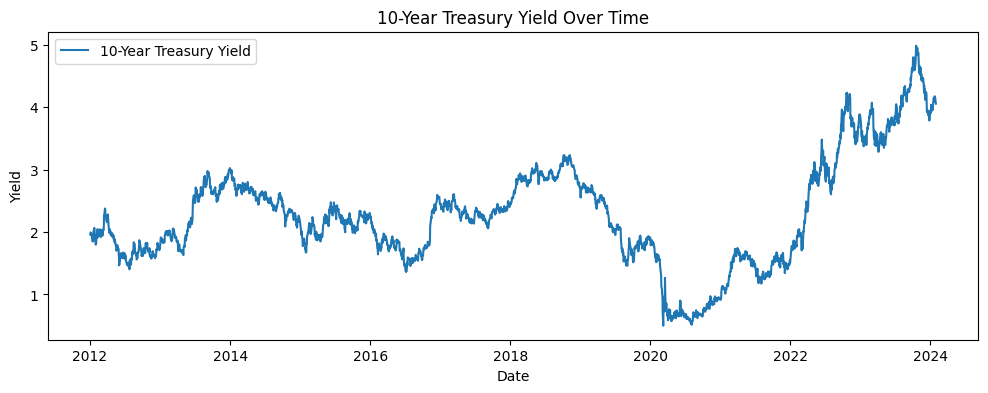

In [30]:
import yfinance as yf
symbol = "^TNX"
start_date = "2012-01-01"
end_date = "2024-01-31"

data = yf.download(symbol, start=start_date, end=end_date)
data = data['Close'].dropna()

rate = data.values

plt.figure(figsize=(12,4))
plt.plot(data, label='10-Year Treasury Yield')
plt.title('10-Year Treasury Yield Over Time')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.show()

In [31]:
df = data.copy()

In [32]:
df.head()

Ticker,^TNX
Date,
2012-01-03,1.960
2012-01-04,1.995
2012-01-05,1.993
2012-01-06,1.961
2012-01-09,1.960


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3037 entries, 2012-01-03 to 2024-01-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ^TNX    3037 non-null   float64
dtypes: float64(1)
memory usage: 47.5 KB


In [34]:
df = df.dropna()
df.index = pd.to_datetime(df.index)
df.head()

Ticker,^TNX
Date,
2012-01-03,1.960
2012-01-04,1.995
2012-01-05,1.993
2012-01-06,1.961
2012-01-09,1.960


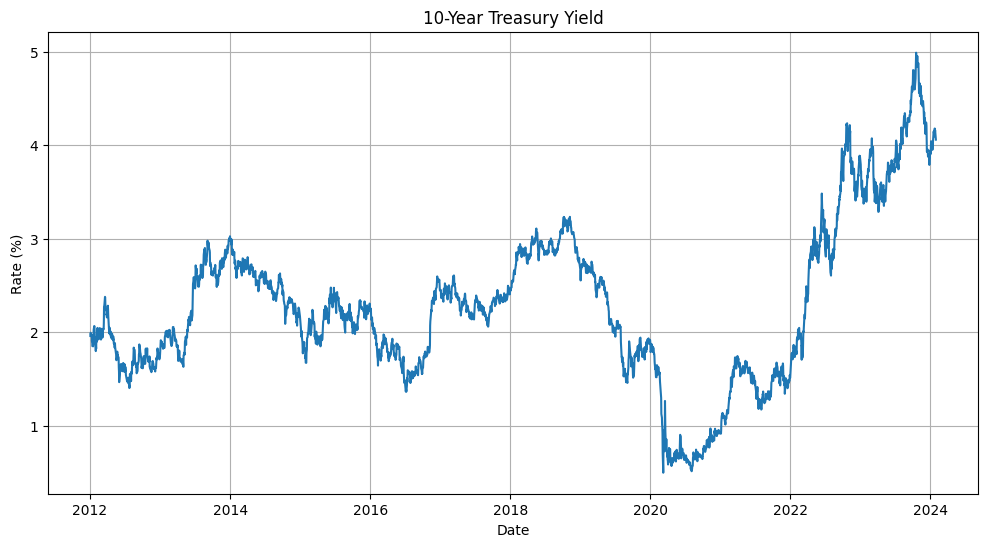

In [36]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x=df.index, y='^TNX')
plt.title('10-Year Treasury Yield')
plt.xlabel('Date')
plt.ylabel('Rate (%)')
plt.grid(True)
plt.show()

### **2. Estimate Vasicek Model Parameters**
OLP Calibrtion Method:

We can calibrate the Vasicek model using standard **Linear Regression (Ordinary Least Squares - OLS)**. 

The dicrete Euler equation for the Vasicek model is given by:
$$r_{t+1}-r_t = a(b-r_t)\Delta t + \sigma \sqrt{\Delta t} \epsilon_t $$

We can rewrite it to look like a linear regression equation: $(Y=\alpha + \beta X + \text{noise}) $

$$\underbrace{r_{t+1}}_{Y} = \underbrace{ab\Delta t}_{\alpha} + \underbrace{(1 - a\Delta t)}_{\beta} \underbrace{r_t}_{X} + \underbrace{\sigma \sqrt{\Delta t} \epsilon_t}_{\text{noise}} $$

Where $\epsilon_t$ is a standard normal random variable.

By running a regression of **the change in rate $(Y)$** against **the current rate $(X)$**, we find estimates for $\alpha$ and $\beta$.

1. Speed of Reversion $(a)$ : $a = \dfrac{1 - \beta}{\Delta t}$
2. Long-term Mean Level $(b)$ : $b = \dfrac{\alpha}{a \Delta t}$
3. Volatility $(\sigma)$ : The standard deviation of the residuals from the regression gives us $\sigma \sqrt{\Delta t}$, so we can compute $\sigma$ as:
   $

In [37]:
def calibrate_vasicek(rates, dt=1/252):
    """
    Calibrates a, b, sigma using OLS on discretized SDE:
    r_{i+1} = a*b*dt + (1 - a*dt)*r_i + sigma*sqrt(dt)*eps
    """
    y = rates.values[1:]
    x = rates.values[:-1]
    X = sm.add_constant(x)
    
    model = sm.OLS(y, X).fit()
    alpha, beta = model.params
    residuals_std = np.std(model.resid)
    
    # Extract parameters from regression coefficients
    a = (1 - beta) / dt
    b = alpha / (a * dt)
    sigma = residuals_std / np.sqrt(dt)
    
    return a, b, sigma

In [38]:
rates = df['^TNX'] / 100
a, b, sigma = calibrate_vasicek(rates,dt=1/252)

print(f"Calibrated Vasicek parameters:")
print(f"a (speed of reversion): {a}")
print(f"b (long-term mean): {b}")
print(f"sigma (volatility): {sigma}")

Calibrated Vasicek parameters:
a (speed of reversion): 0.2911154424136324
b (long-term mean): 0.028783115580092614
sigma (volatility): 0.00816174293304405


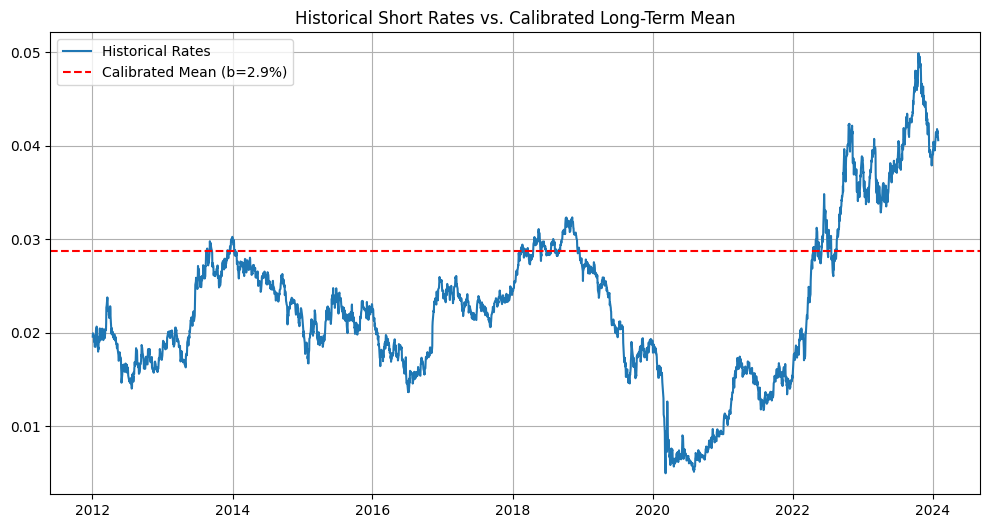

In [39]:
# Optional: Visualize the fit
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['^TNX']/100, label='Historical Rates')
plt.axhline(y=b, color='r', linestyle='--', label=f'Calibrated Mean (b={b:.1%})')
plt.title("Historical Short Rates vs. Calibrated Long-Term Mean")
plt.legend()
plt.grid()
plt.show()

### **3. Simulate Interest Rate Paths**

To simulate the short rate $r_t$ using the Vasicek model, we can use the following discretized version of the SDE:
$$r_{t+\Delta t} = r_t + a(b - r_t)\Delta t + \sigma \sqrt{\Delta t} Z_t$$

where $Z_t$ is a standard normal random variable.

In [40]:
def simulate_vasicek_paths(r0, a, b, sigma, T, dt, n_paths):
    n_steps = int(T / dt)
    rates = np.zeros((n_steps + 1, n_paths))
    rates[0] = r0
    
    for t in range(1, n_steps + 1):
        # dz ~ N(0, sqrt(dt))
        dz = np.random.normal(0, np.sqrt(dt), n_paths)
        # dr = a(b - r)dt + sigma * dW
        rates[t] = rates[t-1] + a * (b - rates[t-1]) * dt + sigma * dz
        
    return rates


C:\Users\mengh\AppData\Local\Temp\ipykernel_2312\3343935822.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  r0 = rates[-1]


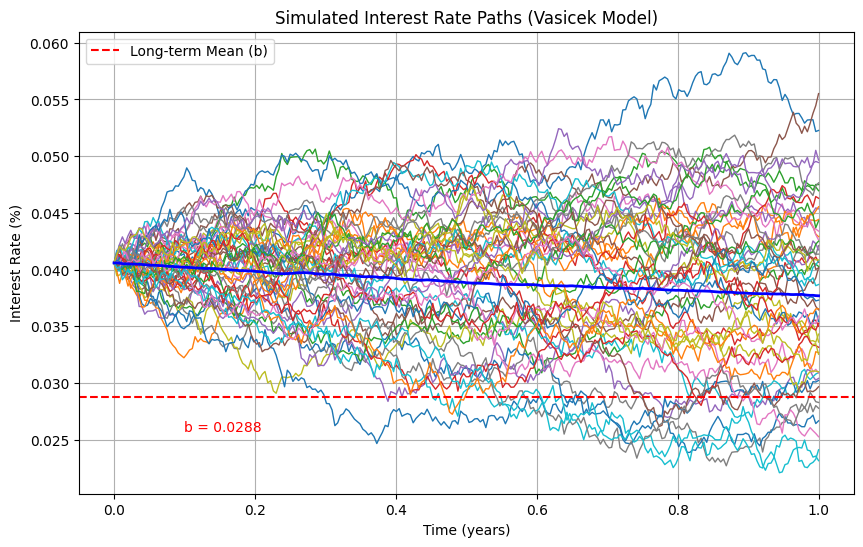

In [41]:
# Simulation parameters
r0 = rates[-1]
T = 1.0  # 1 year
dt = 1/252  # daily steps
n_paths = 1000  # number of simulated paths

rates_sim = simulate_vasicek_paths(r0, a, b, sigma, T, dt, n_paths)
time_grid = np.linspace(0, T, int(T/dt) + 1)

mean_rates = np.mean(rates_sim, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(time_grid, rates_sim[:, :50], lw=1) 
plt.plot(time_grid, mean_rates, lw=2, color='blue')
plt.title('Simulated Interest Rate Paths (Vasicek Model)')
plt.xlabel('Time (years)')
plt.ylabel('Interest Rate (%)')
plt.axhline(y=b, color='r', linestyle='--', label='Long-term Mean (b)')
plt.text(0.1, b - 0.003, f'b = {b:.4f}', color='r')
plt.legend()
plt.grid(True)
plt.show()

### **4. Price Zero-Coupon Bonds**
The price of a zero-coupon bond in the Vasicek model can be calculated using the following formula:
$$P(t,T) = A(t,T) e^{-B(t,T) r_t}$$
where:
- $P(t,T)$ is the price of the bond at time $t$ maturing at time $T$,
- $A(t,T)$ and $B(t,T)$ are functions defined as:

$$B(t,T) = \dfrac{1 - e^{-a(T-t)}}{a}$$

$$A(t,T) = \exp\left( \left( b - \dfrac{\sigma^2}{2a^2} \right) \left( B(t,T) - (T-t) \right) - \dfrac{\sigma^2 B(t,T)^2}{4a} \right)$$


In [43]:
def analytical_bond_price(r, a, b, sigma, T):
    B = (1 - np.exp(-a * T)) / a
    A = np.exp((B - T) * (a**2 * b - 0.5 * sigma**2) / a**2 - (sigma**2 * B**2) / (4 * a))
    P = A * np.exp(-B * r)
    return P

T_bond = 1.0  # 1 year bond
bond_prices = analytical_bond_price(r0, a, b, sigma, T_bond)
print(f"Analytical price of a zero-coupon bond maturing in {T_bond} year(s): {bond_prices:.4f}")

Analytical price of a zero-coupon bond maturing in 1.0 year(s): 0.9617


### **5. Monte Carlo Simulation for Bond Pricing**
To estimate the price of a Zero-Coupon Bond (ZCB) using Monte Carlo simulation, we can follow these steps:

The price of a bond is the risk-neutral expectation of the discounted payoff: 

$$P(0,T) = E^Q\left[e^{-\int_0^T r_t dt}\right]$$

In our simulation, the integral becomes a sum, and the expectation is approximated by the average over many simulated paths.

$$P_{MC} \approx \dfrac{1}{N} \sum_{i=1}^{N}\left( \exp \left(-\sum_{j=0}^{M-1} r_{t_j}^{(i)} \Delta t \right)\right)$$



In [44]:
def price_bond_mc(rates, dt):
    # Stochastic Discount Factor: exp(-integral of r_t dt)
    integral_r = np.sum(rates[:-1, :], axis=0) * dt
    payoffs = np.exp(-integral_r)
    return np.mean(payoffs)

# Price a 1-year bond
T_target = 1.0
steps_target = int(T_target / dt)
mc_price = price_bond_mc(rates_sim[:, :], dt)
analyt_price = analytical_bond_price(r0, a, b, sigma, T_target)

print(f"--- Comparison  ---")
print(f"Analytical Price (1Y): {analyt_price:.5f}")
print(f"Monte Carlo Price (1Y): {mc_price:.5f}")
print(f"Error: {abs(mc_price - analyt_price):.5f}")

--- Comparison  ---
Analytical Price (1Y): 0.96173
Monte Carlo Price (1Y): 0.96175
Error: 0.00001


### 5.2 Compare 

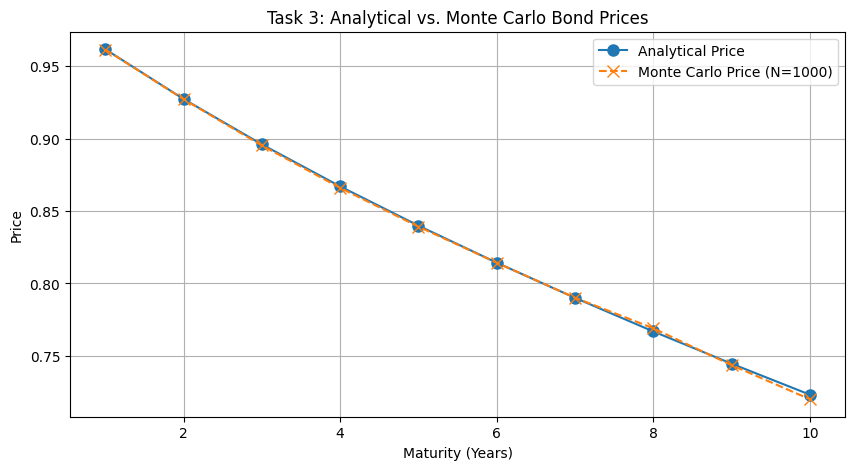

In [45]:
# Parameters
T_max = 10
dt = 1/252


maturities = np.arange(1,T_max+1)
analytical_prices = [analytical_bond_price(r0, a, b, sigma, T) for T in maturities]

# Monte Carlo
n_paths = 1000
mc_prices = []
for T in maturities:
    full_paths = simulate_vasicek_paths(r0, a, b, sigma, T, dt, n_paths)
    integral_r = np.sum(full_paths, axis=0)*dt
    mc_prices.append(np.mean(np.exp(-integral_r)))

plt.figure(figsize=(10, 5))
plt.plot(maturities, analytical_prices, 'o-', label='Analytical Price', markersize=8)
plt.plot(maturities, mc_prices, 'x--', label=f'Monte Carlo Price (N={n_paths})', markersize=8)
plt.title("Task 3: Analytical vs. Monte Carlo Bond Prices")
plt.xlabel("Maturity (Years)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [46]:
absolute_errors = [abs(ap - mp) for ap, mp in zip(analytical_prices, mc_prices)]

comparison_df = pd.DataFrame({
    'Maturity (Years)': maturities,
    'Analytical Price': analytical_prices,
    f'Monte Carlo Price (N={n_paths})': mc_prices,
    'Absolute Error': absolute_errors
})

comparison_df

,Maturity (Years),Analytical Price,Monte Carlo Price (N=1000),Absolute Error
0,1,0.961734,0.961529,0.000205
1,2,0.927366,0.927190,0.000176
2,3,0.896006,0.895275,0.000731
3,4,0.867007,0.865980,0.001027
4,5,0.839894,0.839199,0.000695
5,6,0.814320,0.814280,0.000040
6,7,0.790027,0.790127,0.000099
7,8,0.766825,0.769030,0.002205
8,9,0.744570,0.743563,0.001008
9,10,0.723155,0.719999,0.003156


### **6. Yield Curve Analysis**

Using the analytical bond pricing formula, generate the yield curve for different maturities $ T $ by calculating the yield $ y(0,T) $:
    $$ y(0,T) = -\frac{1}{T} \ln(P(0,T)) $$

- Analyze how changes in parameters $ a $, $ b $, and $ \sigma $ affect the shape of the yield curve.

In [47]:
maturities = np.linspace(0.1, 10, 100)

def get_yields(a, b, sigma):
    prices = [analytical_bond_price(r0, a, b, sigma, T) for T in maturities]
    return -np.log(prices) / maturities

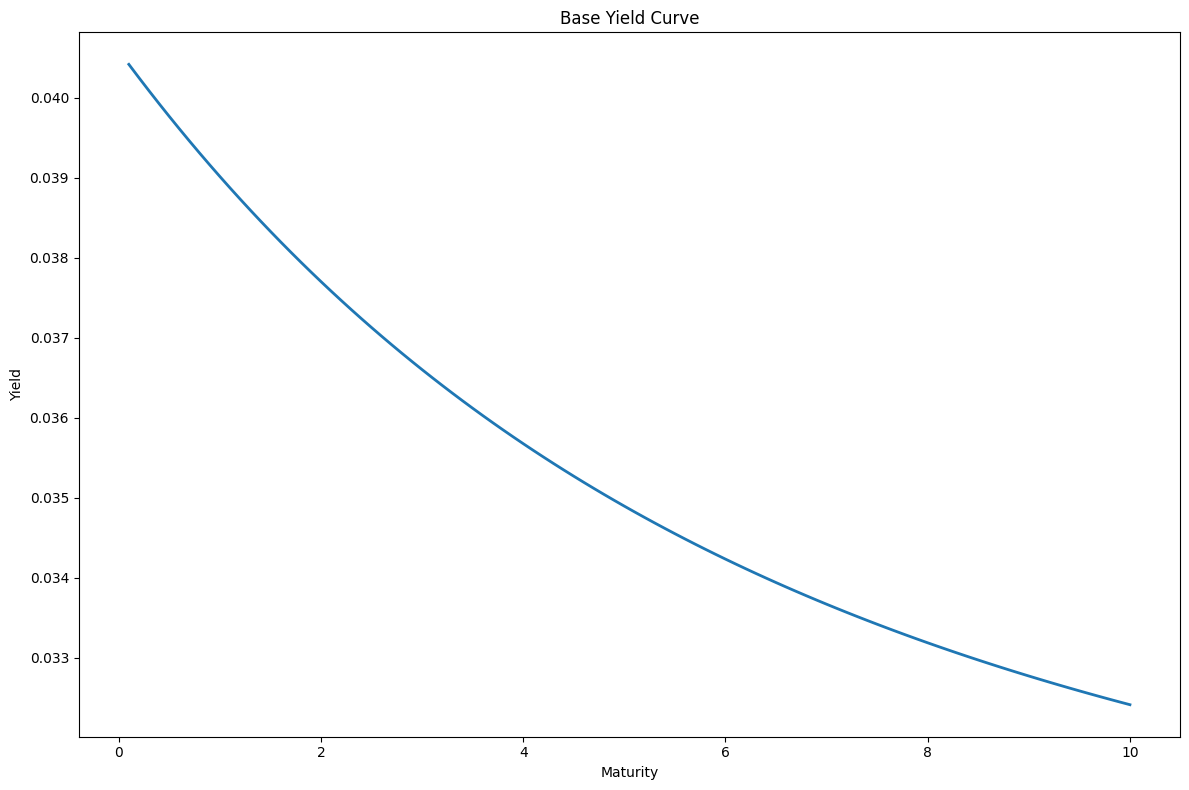

In [49]:
plt.figure(figsize=(12, 8))
plt.plot(maturities, get_yields(a, b, sigma), label='Base Case', lw=2)
plt.title("Base Yield Curve")
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.tight_layout()
plt.show()

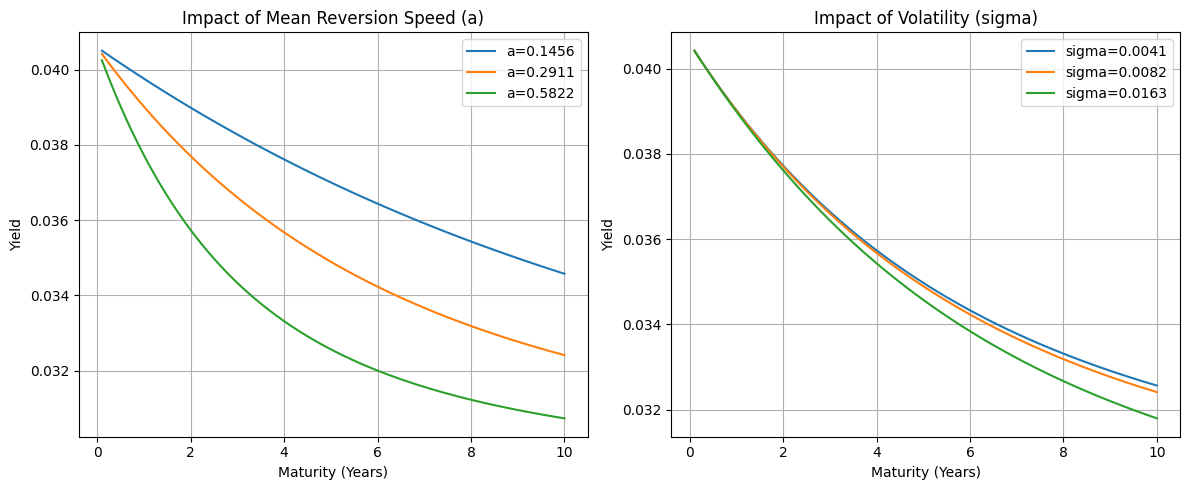

In [52]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

a_imp = [a/2, a, a*2]
for a_val in a_imp:
    yields = get_yields(a_val, b, sigma)
    plt.plot(maturities, yields, label=f'a={a_val:.4f}')
plt.title("Impact of Mean Reversion Speed (a)")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield")
plt.legend()
plt.grid(True)

# Scenario B: Effect of 'sigma' (Volatility)
sigma_imp = [sigma/2, sigma, sigma*2]
plt.subplot(1, 2, 2)
for sig_val in sigma_imp:
    yields = get_yields(a, b, sig_val)
    plt.plot(maturities, yields, label=f'sigma={sig_val:.4f}')
plt.title("Impact of Volatility (sigma)")
plt.xlabel("Maturity (Years)")
plt.ylabel("Yield")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

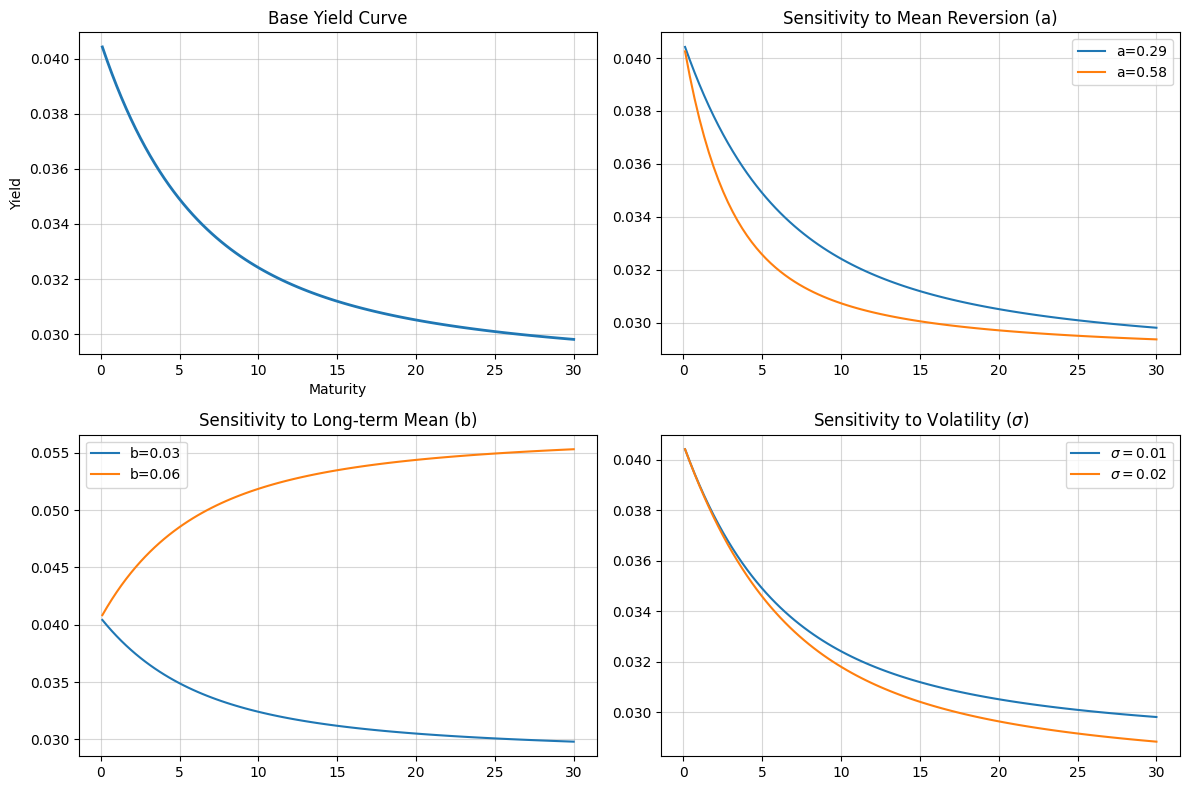

In [56]:
# Task 4: Yield Curve and Sensitivity
m_yields = np.linspace(0.1, 30, 100)
def get_yields(a, b, sigma):
    prices = [analytical_bond_price(r0, a, b, sigma, T) for T in m_yields]
    return -np.log(prices) / m_yields

plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(m_yields, get_yields(a, b, sigma), label='Base Case', lw=2)
plt.title("Base Yield Curve")
plt.xlabel("Maturity")
plt.ylabel("Yield")
plt.grid(alpha=0.5)

plt.subplot(2, 2, 2)
plt.plot(m_yields, get_yields(a, b, sigma), label=f'a={a:.2f}')
plt.plot(m_yields, get_yields(2*a, b, sigma), label=f'a={2*a:.2f}')
plt.title("Sensitivity to Mean Reversion (a)")
plt.legend()
plt.grid(alpha=0.5)

plt.subplot(2, 2, 3)
plt.plot(m_yields, get_yields(a, b, sigma), label=f'b={b:.2f}')
plt.plot(m_yields, get_yields(a, 2*b, sigma), label=f'b={2*b:.2f}')
plt.title("Sensitivity to Long-term Mean (b)")
plt.legend()
plt.grid(alpha=0.5)

plt.subplot(2, 2, 4)
plt.plot(m_yields, get_yields(a, b, sigma), label=f'$\sigma={sigma:.2f}$')
plt.plot(m_yields, get_yields(a, b, 2*sigma), label=f'$\sigma={2*sigma:.2f}$')
plt.title("Sensitivity to Volatility ($\sigma$)")
plt.legend()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()